data length 10149
-0.36635894588091644
(100, 2)


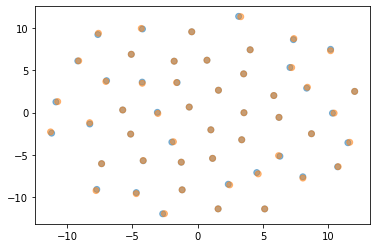

In [15]:
from mtv import model
from bson import ObjectId
from mongoengine import connect


connect(db='mtv', host='localhost', port=27017, username=None, password=None)

predictions = list()
doc = model.Prediction.find_one(datarun=ObjectId('5da7d08776e3e19307d0dbf6'))
data = doc.data
print('data length', len(data))
print(data[0][1])


def get_X(start_index, stop_index, window_size=100, step_size=1):
    X = list()
    while start_index <= stop_index:
        x = []
        for i in range(window_size):
            x.append(data[start_index - i][1])  # y_raw
        x.reverse()
        X.append(x)
        start_index += step_size
    return X

len1 = 50
len2 = 50
X1 = get_X(850, 850 + len1-1)
X2 = X1.copy()
# X2 = get_X(5600, 5600 + len2-1)

X = X1 + X2
# X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1]] + [[1,1,1]] * 30)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import similaritymeasures as sm

def compute_distance(x1, x2):
    x1_ = np.zeros((len(x1), 2))
    x1_[:, 0] = np.arange(len(x1))
    x1_[:, 1] = x1
    x2_ = np.zeros((len(x2), 2))
    x2_[:, 0] = np.arange(len(x2))
    x2_[:, 1] = x2
    
    dist, _ = sm.dtw(x1_, x2_)
    return dist
    
X = np.array(X)
X_embedded = TSNE(n_components=2, learning_rate=25, n_iter=5000, metric=compute_distance).fit_transform(X)
print(X_embedded.shape)

c = ['#1f77b4'] * len1 + ['#ff7f0e'] * len2

# # plt.scatter(X_embedded[:,0], X_embedded[:,1], s=area, c=colors, alpha=0.5)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=c, alpha=0.5)
plt.show()



In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


N = 50
x = np.random.rand(N)
print(x)
y = np.random.rand(N)
colors = np.random.rand(N)
# area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

# plt.scatter(x, y, s=area, c=colors, alpha=0.5)
# plt.show()

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

z = [0] * 25 + [1] * 25
# sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
sns.scatterplot(x, y, hue=z, legend='full', palette=palette)

[0.7003673  0.74275081 0.70928001 0.56674552 0.97778533 0.70633485
 0.24791576 0.15788335 0.69769852 0.71995667 0.25774443 0.34154678
 0.96876117 0.6945071  0.46638326 0.7028127  0.51178587 0.92874137
 0.7397693  0.62243903 0.65154547 0.39680761 0.54323939 0.79989953
 0.72154473 0.29536398 0.16094588 0.20612551 0.13432539 0.48060502
 0.34252181 0.36296929 0.97291764 0.11094361 0.38826409 0.78306588
 0.97289726 0.48320961 0.33642111 0.56741904 0.04794151 0.38893703
 0.90630365 0.16101821 0.74362113 0.63297416 0.32418002 0.92237653
 0.23722644 0.82394557]


ValueError: The palette list has the wrong number of colors.

In [8]:
import similaritymeasures as sm

d, d_ = sm.dtw([[0,1], [1,2], [2,3], [3,4]], [[0,1], [1,2], [2,5], [3,4]])
print(d)

d, d_ = sm.dtw([[0,1], [1,2], [2,3], [3,4]], [[0,1], [1,2], [2,3], [3,4]])
print(d)


2.0
0.0
